# ASL Classification Neural Network Design Document
This document outlines the design and implementation of a Fully Connected Deep Neural Network designed to classify American Sign Language (ASL) hand gestures from images.


At its core, this system transforms 28x28 pixel grayscale images into predictions across 24 classes, representing the static letters of the ASL alphabet (excluding J and Z which require motion). While deep neural networks can have many hidden layers, we will begin with a simple three-layer architecture to clearly understand how each component works.


![Model](./mlp_1_layer.png)

## Core Components
**Input Layer**: The input layer serves as the entry point for our neural network, accepting flattened 28×28 pixel grayscale images. Each unit represents one normalized pixel value (which we will need to scale to 0-1), effectively unfolding a square image into a single line of numbers for processing.

**Hidden Layer**: In our base model, the hidden layer will be composed of 200 hidden units. In this layer, the first transformation will ocurr.

``` python
z¹ = W¹X + b¹    (Linear combination)
a¹ = ReLU(z¹)    (Non-linear activation)
```

Where $Z^1$ is know as net input function and the (1) superscript represents the number of layer in which the function is applied. The $a^1$ function represents the activation function, a ReLU in this specific example, this ReLU will introduce a non linear component, that among other things, will help our model to learn complex patters from our training data. In resume, the hidden layer will connect every input unit to hidden activation units through weights $W^1$.


**Output Layer**: The output layer will receive the signal from the hidden layer and will use it to calculate the net input $Z^2$ which will represent a raw and unnormalized version of the predictions, these are also know as logits, and they will be the input of our next activation function, the softmax function which will process the logits and will generates predictions using softmax activation which generates a probability distribution across all possible classes.

``` python
z² = W²a¹ + b²   (Linear combination)
ŷ = softmax(z²)  (Prediction-using Probability distribution)
```

This basic architecture achieves approximately 70% accuracy and serves as our foundation for further development.


## Forward and backward propagations
In this section, we will explore the data flow through the forward and backward propagation process. This will provide intuition that will help us debug and implement the model later. We will connect the mathematical equations underlying the model with their corresponding code implementation in later sections.
### Forward pass
In our first step the model will be to compute the forward pass between the input layer and the hidden layer. This can be expresed in this equations:
$$z^1 = W^1 X^T + b^1$$
$$a^1 = ReLU(z^1)$$
Let’s assign some values with the data we will apply on this exercise:
```python
n = 512 # number of samples in mini batch (512 for this example)
m = 784 # number of input features (28x28) flattened image
d = 200 # number of hidden units (example)
t = 24 # number of output units, given by the number of classes in our target variable

### Input layer
X.shape # (n=512,m=784)
W1.shape # (d=200,m=784)
b1.shape # (d=200,1)
W2.shape # (t=24,d=200)
b2.shape # (t=24,1)
```

At the end of this operations, our tensor’s shape will be transformed into a shape of (d=200, n=512) , which will be inline with the number of hidden neurons and the size of our minibatch. We can visualize the operations taking part as below:
```python
# Z1 =    W1      @     X.T     +   b1
#      (200, 784) @ (784, 512) + (200, 1)
Z1.shape # (200, 512)

# A1 = ReLU(Z1)
A1.shape # (200, 512)
```

<aside> 💡
Note that we transpose the 'X' tensor from(512, 784)to(784, 512)to enable matrix multiplication. Different implementations may use different tensor shapes for the matrix multiplication in our net input function $Z$. For instance, with shapesW(d,m)andX(m,n), we can multiply using just W @ X. Or with shapesX(n,m)andW(d,m), we useX @ W.T. Regardless of the implementation, the rules of linear algebra must be followed—the internal dimensions must match for multiplication to work.
</aside>

In the next transformation, from the hidden layer to the output layer. The involved equations will be:
$$ z^2 = W^2 a^1 + b^2 $$
$$ \hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}} $$
And the tensor’s shape will be transform as follows

```python
# Z2 =     W2    @     A1     +  b2
#      (24, 200) @ (200, 512) + (24, 1)
Z2.shape # (24, 512)

# y^ = softmax(Z2)
y_hat.shape # (24, 512)
```

Our final output $\hat{y}$ will be a tensor of shape (24, 512), where each row will contain the probability of each class in our ASL dataset. And each column will contain the results for each sample in our mini batch.


### Backpropagation Pass
Let's discuss the backpropagation process. The objective of backpropagation is to find the weights and biases that minimize the loss function. In other words, we need to optimize a function that measures our model's error rate. To do this, we first need to understand what the loss function looks like.
### The loss function

This equation calculate the loss for each sample in our mini batch.
$$\mathcal{L}(\hat{y}^{i}, y^{i}) = - y^{i} \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$

And this equation calculate the average loss for all samples in our mini batch.

$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$


The loss function depends on the final transformation of our model—the softmax function. Therefore, our first partial derivative in the chain rule begins from the softmax function. Our derivatives are calculated from right to left, moving from the last layer to the first layer, which is computationally more efficient.


### Updating our weights and biases
In order to reduce the value of our loss function we need to update the values of our model’s weights and biases. We do this by performing the following operations
$$W:= W + \Delta W$$
$$b := b + \Delta b$$


Where the `:=` symbol would be same as in code operation  `x += 1`, which represents an operation where we add a value of 1 to x.



We need to apply this $\Delta$ update to each of our weights and biases. Our model has two sets: one in the hidden layer and another in the output layer. The equations to obtain the update for our hidden layer are:
$$\Delta w^{(h)} := - \eta \frac{\partial L}{\partial w^{(h)}}w^{(h)}$$
And for the corresponding biases:
$$\Delta b^{(h)} := - \eta \frac{\partial L}{\partial b^{(h)}}$$
Where $\eta$ is the learning rate and the partial derivatives of the loss are computed with respect to the weights and biases.
We can apply the chain rule to the the functions that conform our model and we would obtain the following equation:

$$\frac{\partial \mathcal{L}}{\partial w^{h}} = \frac{\partial \mathcal{L}}{\partial \text{softmax}^{out}} \cdot \frac{\partial \text{softmax}^{out}}{\partial z^{out}} \cdot \frac{\partial z^{out}}{\partial ReLU^{h}} \cdot \frac{\partial ReLU^{h}}{\partial z^{h}} \cdot \frac{\partial z^{h}}{\partial w^{h}}$$

Derivates from left to right:
- The loss to the softmax activation function
- The softmax activation to the output's net input Z
- The output's net input Z to the hidden activation function (A ReLU)
- The hidden activation function (A ReLU) to the hidden net input Z
- The hidden net input Z to the hidden weights W


A naive implementation of these equations would require calculating the derivative at each pass of our training loop. Although conceptually we are making two loops (a forward and backward loop) to obtain the update values, in practice this would be computationally expensive. Thus, a proper implementation requires a different approach, in which both the forward transformations and their corresponding gradients are computed in a single pass.


    



# Implementation

## Overview

The implementation of our model consists of two stages: data pre-processing and algorithm implementation.
The data preprocessing stage consists of functions that prepare the data for the model. These functions separate target variables (classes) from feature inputs, split the data into training, validation, and test sets, and normalize values. These standard preprocessing steps prepare raw data for use in deep learning models. The output of these stage will be the input of the DNN implementation stage, we will build a training pipeline as depicted in the image below:





![Components](./components.png)


At the core is the `Sequential_Layers` (1), which acts as a container orchestrating three main computational units: 
- the Linear Layers (2)
- ReLU activation (3). 

We will discuss how this is done in detail in the next part. The output of this equation layer is then pass to a Softmax Cross Entropy (4) function, which is responsible for:
- Processing the raw logits from previous linear layer
- Obtain the prediction (by applying softmax)
- Comput the loss for the epoch
- Compute and store the gradient for the backpropagation


The training process is orchestated by our train function (5), which coordinates the forward pass through the Sequential Layer and backward propagation of gradients, this function receives the number of epochs and training rate parameters which configure the training process. Our training process tracks the progress with the accuracy function (6) which monitors model performance during training.

Finally, the function `plot_training_progress` (7) provides visual feedback on the learning process in our monitoring and evaluation phase.

We will being the implementation starting with the Data processing stage.

## Data processing

### Exploring the data
Lets begin by exploring the contents of our dataset to get a notion of some of the parameters that our model will be using



In [1]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

# Lets load the data
DATA_PATH = '.'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))
print(f"shape of train_df: {train_df.shape}")
print(f"shape of valid_df: {valid_df.shape}")
print(f"number of classes: {valid_df.label.nunique()}")
# Get min and max pixel values
pixel_max = max(train_df.iloc[:, 1:].max().max(), valid_df.iloc[:, 1:].max().max())
pixel_min = min(train_df.iloc[:, 1:].min().min(), valid_df.iloc[:, 1:].min().min())
print(f"Pixel value range: min = {pixel_min}, max = {pixel_max}")

train_df.head()



shape of train_df: (27455, 785)
shape of valid_df: (7172, 785)
number of classes: 24
Pixel value range: min = 0, max = 255


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


- We notice that our training dataset is made of 27455 in our training set and 7172 in our validation set.
- We can observe that our sets have 785 columns, specifically the one titled 'label' corresponds to our target variable and contains 24 different classes, this give us an idea of the number of units in our output layer.
- We also notice that the remaining number of columns is 784 which is result of 28x28, which would indicate that the images have been already flattened in the dataset. We can test this by building a function that re-sizes the images to their original size and plot them.
- The values of the dataframe are all integers. Given that neural networks are sensitive to the scale of input features (weights are typically initialized to small random values), and that the gradient descent can compute gradients that can be different in magnitude across features, it's a good idea to normalize the data to avoid issues with the stability of our training.
- The values in our pixels are from 0 to 255


### Utility functions
As mentioned before we will need to apply some preprocessing before begining the training our neural network. In this section we will build some utility functions that will help us apply operations such as:
- data splits
- data normalization
- data visualization



In [2]:
#### ---------- Utility functions ----------
def get_asl_alphabet():
    """
    Returns a list of lowercase letters excluding 'j' and 'z' which are used in ASL.
    The ASL dataset excludes 'j' and 'z' because they require motion and cannot be represented in static images.
    In order to identify our 24 classes we will need to match the selected 24 letters with the 24 classes in our dataset.
    
    Returns:
        list: List of 24 lowercase letters used in static ASL hand positions
    """
    alphabet = list(string.ascii_lowercase)
    alphabet.remove('j')  # The letter 'j' in ASL requires motion
    alphabet.remove('z')  # The letter 'z' in ASL requires motion
    return alphabet

### ---------- Data splitting functions ----------
def split_val_test(x, y, pct=0.5, shuffle=True):
    '''
    Splits data into validation and test sets.
    
    Args:
        x: Input features array
        y: Labels array
        pct: Fraction of data for validation set (0-1)
        shuffle: Whether to shuffle before splitting
    '''
    # Get total number of samples
    n_samples = len(x)
    
    # Create array of indices for shuffling
    indices = np.arange(n_samples)
    if shuffle:
        np.random.shuffle(indices)
    
    # Calculate split point and divide indices
    split_idx = int(n_samples * pct)
    val_indices = indices[:split_idx]    # First pct% for validation
    test_indices = indices[split_idx:]   # Remaining for test
    
    # Return split datasets using index arrays
    return x[val_indices], y[val_indices], x[test_indices], y[test_indices]

#### ---------- Normalization functions ----------
def normalize_data(x_train, x_val, x_test):
    """
    Normalize image data to [0,1] range by dividing by 255.
    
    Args:
        x_train (np.ndarray): Training data
        x_val (np.ndarray): Validation data
        x_test (np.ndarray): Test data
        
    Returns:
        tuple: Normalized (x_train, x_val, x_test)
    """
    # Normalize to [0,1] range
    x_train_norm = x_train / 255.0
    x_val_norm = x_val / 255.0
    x_test_norm = x_test / 255.0
    
    return x_train_norm, x_val_norm, x_test_norm

### ---------- Minibatch generator ----------
def create_minibatches(mb_size, x, y, shuffle=True):
    """
    Creates mini-batches from input data for training neural networks.
    
    Args:
        mb_size (int): Size of each mini-batch
        x (np.ndarray): Input features array of shape (n_samples, 784)
        y (np.ndarray): Target labels array of shape (n_samples, 1)
        shuffle (bool): Whether to shuffle the data before creating mini-batches
    
    Returns:
        generator: Generator yielding tuples of (x_batch, y_batch)
    """    
    assert x.shape[0] == y.shape[0], 'Error: number of samples in x and y must match'
    total_data = x.shape[0]
    
    if shuffle: 
        # shuffle indexes        
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    
    # Create generator that yields batches of data
    # For each iteration:
    # - i increments by mb_size (e.g., 0, 32, 64, ...)
    # - x[i:i+mb_size] takes a slice of mb_size samples from x
    # - y[i:i+mb_size] takes corresponding labels from y
    # - Returns tuple of (x_batch, y_batch)
    minibatch = ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))
    return minibatch

#### ---------- Data visualization functions ----------

def plot_sample_signs(x_data, y_data, num_samples=5):
    """
    Plot multiple random samples from the dataset.
    
    Args:
        x_data (np.ndarray): Image data
        y_data (np.ndarray): Labels
        num_samples (int): Number of samples to plot
    """
    plt.figure(figsize=(15, 3))
    
    for i in range(num_samples):
        idx = np.random.randint(len(y_data))
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(x_data[idx].reshape(28, 28), cmap='gray')
        plt.title(f'Label: {get_asl_alphabet()[y_data[idx]]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


Now with all our utilities in place, we can proceed to prepare our data in a format that our model can work with.
1. Separate our features from our target variables
2. Our data is made of integers, we will convert them to floats.
3. We will divide our data into training, validation and test dataframes
4. Then we will proceed with the normalization.
5. And finally we will inspect the shape of our dataframes to make sure they are in the correct format and we will plot some of the images from the ASL dataset.


x_train_norm.shape: (27455, 784)
x_val_norm.shape: (3586, 784)
x_test_norm.shape: (3586, 784)


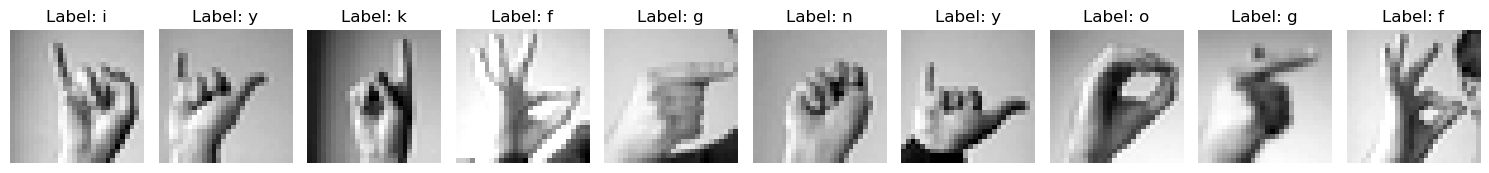

In [3]:
# 1. separate our features from our target variables 
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
# And remove it from our train_df and valid_df dataframes
del train_df['label']
del valid_df['label']

# 2.Cast to float32
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

# 3. Split data into training, validation and test sets
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

# 4. Normalize data
x_train_norm, x_val_norm, x_test_norm = normalize_data(x_train, x_val, x_test)

# 5. Inspect the shape of our dataframes to make sure they are in the correct format and we will plot some of the images from the ASL dataset.
print(f"x_train_norm.shape: {x_train_norm.shape}")
print(f"x_val_norm.shape: {x_val_norm.shape}")
print(f"x_test_norm.shape: {x_test_norm.shape}")
# Plot 10 random samples from validation data
plot_sample_signs(x_train, y_train, num_samples=10)


# DNN Implementation

### The sequential layer
The Sequential_layers class serves as the main container and orchestrator for our neural network. It manages the sequential flow of data through layers, handles the storage of intermediate computations, and coordinates both forward and backward propagation. Think of it as the "assembly line" of our neural network, where each layer processes the data in sequence.


In [4]:
class Sequential_layers():
    """
    A sequential container for neural network layers that handles forward propagation,
    backward propagation, and parameter updates.
    """
    
    def __init__(self, layers):
        # [1] Initialize container attributes
        self.layers = layers            # Store layer sequence
        self.x = None                   # Current input placeholder
        self.outputs = {}               # Cache for intermediate values
        
    def __call__(self, X):
        # [2] Start forward propagation sequence
        self.x = X 
        self.outputs['l0'] = self.x     # Store input as first output
        
        # [3] Iterate through layers sequentially
        for i, layer in enumerate(self.layers, 1):
            # [4] Process and store each layer's output
            self.x = layer(self.x)                  # Transform data
            self.outputs['l'+str(i)] = self.x       # Cache output
        return self.x
        
    def backward(self):
        # [5] Initialize backward pass
        for i in reversed(range(len(self.layers))):
            # [6] Backward propagation through each layer
            self.layers[i].backward(
                self.outputs['l'+str(i)],     # Input to current layer
                self.outputs['l'+str(i+1)]    # Output from current layer
            )
    
    def update(self, learning_rate=1e-3):
        # [7] Parameter update loop
        for layer in self.layers:
            # [8] Skip ReLU layers (no parameters)
            if isinstance(layer, ReLU): continue
            
            # [9] Update weights and biases
            layer.W = layer.W - learning_rate * layer.W.grad
            layer.b = layer.b - learning_rate * layer.b.grad
            

    #[10] Utility function to predict a batch of data
    def predict(self, X):
        """
        Generate predictions for input data.
        
        Args:
            X: Input data (can be single sample or batch)
        Returns:
            np.ndarray: Array of predicted class indices
        """
        # Get model outputs
        scores = self.__call__(X)
        # Return predicted classes
        return np.argmax(scores, axis=0)


The constructor initializes [1] three essential attributes: layers (which stores the sequence of layer objects like Linear and ReLU), x (a placeholder for the current input being processed), and outputs (a dictionary that stores intermediate values needed for backpropagation).


The [2] __call__ function serves as a common interface that our layer components will implement, this function will initiate the forward propagation by storing the input data and creating the first entry in the outputs cache with key 'l0', which will be essential for computing gradients during backpropagation. [3] Then it will initiate a sequatial iteration through the rest of the model layers (thus our naming “sequential layer”), [4] it will Store each layer's output in the outputs dictionary for later use, so the transformed data becomes the input for the next layer.


[5] The backward pass begins from the last layer and moves to the first using reversed() iteration. [6] Each layer's backward method is called with its input and output from the outputs dictionary, enabling gradient computation through the chain rule.


At this moment [7] our layers will contain the computed gradients to adjust weights and biases values that we need to apply to continue with the training. We can skip the [8] ReLU layers since they have no parameters to update. After updating our weight and biases [9], we are ready to another epoch training cycle.
Finally, we will create a prediction function [10] which will apply the softmax to our logits comming from the last layer of our model and generate predictions from a batch of samples. It is important to notice that this function will only be used to test our model predictions, in other words, this function is only used for inference as in the traning loop we will need to use softmax as in our training loop, we will apply softmax.
Here an example:

```python
Imagine we have these logits [-1.0, 2.0, 0.5]:
Softmax ≈ [0.05, 0.71, 0.24] (probabilities)
Argmax = 1 (index of highest value)
Softmax preserves relative differences between logits as probabilities, while argmax only cares about which logit is largest which makes it ideal for inference.
```




## Linear Layer
The Linear class implements a fully connected layer in our neural network, performing the affine transformation Z = WX + b. This layer contains learnable parameters (weights W and bias b) and handles both forward propagation (computing outputs) and backward propagation (computing gradients) for these parameters.


In [5]:
class np_tensor(np.ndarray): pass

class Linear():
    """Linear layer implementing affine transformation Z = WX + b with gradient tracking."""
    
    def __init__(self, input_size, output_size):
        # [1] Initialize weights using He initialization
        self.W = (np.random.randn(output_size, input_size) / 
                 np.sqrt(input_size/2)).view(np_tensor)
        
        # [2] Initialize bias vector with zeros
        self.b = (np.zeros((output_size, 1))).view(np_tensor)
        
    # [3] Compute forward pass: Z = WX + b
    def __call__(self, X):
        
        Z = self.W @ X + self.b
        return Z
     
     # [4] Compute input gradients   
    def backward(self, X, Z):       
        X.grad = self.W.T @ Z.grad    
        self.W.grad = Z.grad @ X.T 
        self.b.grad = np.sum(Z.grad, axis=1, keepdims=True) 

[1] Weight Initialization uses He initialization for weights with shape (output_size, input_size) for matrix multiplication compatibility. This initialization helps prevent vanishing/exploding gradients, especially with ReLU activation. [2] Bias Initialization creates a zero-initialized bias vector of shape (output_size, 1), which is converted to np_tensor type for gradient tracking.


The __call__ [3] function will implement the net input function Z = WX + b, which we have been familiarized in previous sections. But the novelty here is the computation of the [4] backward pass, notice that parent layer (sequential layer) will initiate the backward function call sequentially on each of its internal layers, so each layer can calculate the required gradients to update its corresponding weights and biases. So W.grad is the gradient for weights of current layer, same as b.grad is the gradient for the biases. X.grad stores the gradient of the loss with respect to the input features, which is needed for backpropagation to previous layers. Let’s review a simple example, in our model we have:

```python
X -> Linear1 -> ReLU -> Linear2 -> Softmax
```

When Linear2's backward() runs:
- Its computed value for X.grad becomes ReLU's Z.grad
- ReLU uses this to compute its own X.grad
- Which becomes Linear1's Z.grad
- And so on backwards through the network



### ReLU Activation
The ReLU (Rectified Linear Unit) class implements a non-linear activation function that transforms its input by outputting zero for all negative values and keeping positive values unchanged. This non-linearity is crucial as it allows the network to learn complex patterns while maintaining simple and efficient computation.


In [6]:
class ReLU():
    """ReLU activation layer that applies max(0,x) operation with gradient masking."""
    
    def __call__(self, Z):
        # [1] Forward pass: max(0,x) operation
        return np.maximum(0, Z)  # Element-wise comparison and selection
    
    def backward(self, Z, A):
        # [2] Initialize gradient computation with upstream gradients
        Z.grad = A.grad.copy()   # Copy to avoid modifying upstream gradients
        
        # [3] Apply ReLU gradient mask
        Z.grad[Z <= 0] = 0       # Gradient is 0 where input was <= 0

In the forward pass [1], it uses NumPy's maximum function to implement f(x) = max(0,x), which preserves positive values outputing zero for the negatives.
During backpropagation, the class first handles the upstream gradients [2] by creating a copy of A.grad to avoid modifying the original gradient values that may be needed by other parts of the network. Then [3], it applies the ReLU derivative by creating a binary mask - keeping the gradient unchanged where the original input was positive (>0) and setting it to zero where the input was negative or zero (≤0). This masking effectively implements the ReLU derivative: f'(x) = 1 if x > 0, else 0. The combination of simple forward computation and sparse gradient flow makes ReLU computationally efficient while helping mitigate the vanishing gradient problem.


### Softmax Cross-Entropy
The softmaxXEntropy function implements the combined softmax activation and cross-entropy loss calculation, this will be used as the final layer in classification networks. It converts network outputs into probabilities and computes the loss in a numerically stable way, while also providing gradients for backpropagation.


In [7]:
def softmaxXEntropy(x, y):
    """
    Compute softmax activation and cross-entropy loss with gradients.
    
    Args:
        x: Input logits of shape (num_classes, batch_size)
        y: True labels
    Returns:
        tuple: (predictions, loss)
    """
    # [1] Get batch dimensions for processing
    batch_size = x.shape[1]  # Expects shape (num_classes, batch_size)
    
    # [2] Softmax forward pass
    exp_scores = np.exp(x)                           # Exponential of inputs
    probs = exp_scores / exp_scores.sum(axis=0)      # Normalize across classes
    preds = probs.copy()                             # Store for return value
    
    # [3] Cross-entropy loss computation
    # Select probability for correct class of each example
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    # Compute average negative log likelihood
    cost = np.sum(-np.log(y_hat)) / batch_size
    
    # [4] Gradient computation
    # Gradient of softmax + cross-entropy
    probs[y.squeeze(), np.arange(batch_size)] -= 1
    # Store for backpropagation
    x.grad = probs.copy()
    
    return preds, cost

At [1], it extracts the batch size from input shape (num_classes, batch_size) to enable batch processing. Then [2] it computes the class probabilities using softmax. Then the output is used to calculate the cross-entropy loss[3], and finally [4], the computes the gradient computation that is stored in the X.grad, iniatializing the first X.grad of the backpropagation chain.

### Accuracy
The accuracy function evaluates model performance by efficiently processing data in mini-batches to handle large datasets while maintaining memory efficiency. It initializes counters to track correct predictions and total examples, then processes the data batch by batch using create_minibatches. For each batch, it generates predictions by passing the transposed input through the model and using argmax to get predicted class indices, which are compared against true labels to count correct predictions. The function accumulates these counts across all batches and finally returns the overall accuracy as the ratio of correct predictions to total examples processed. Notice we are using the argmax as we want to record the improvement on the model after the training step.


In [8]:
# Accuracy function
def accuracy(x, y, mb_size, model):
    """
    Calculate model accuracy across mini-batches.
    
    Args:
        x: Input features
        y: True labels
        mb_size: Mini-batch size
        model: Neural network model
    Returns:
        float: Accuracy score (0-1)
    """
    correct = 0
    total = 0
    
    for i, (x_batch, y_batch) in enumerate(create_minibatches(mb_size, x, y)):
        # Get model predictions
        logits = model(x_batch.T.view(np_tensor))
        pred = np.argmax(logits, axis=0)
        
        # Compare predictions with labels
        correct += np.sum(pred == y_batch.squeeze())
        
        # Update total count using batch size
        total += len(pred)
    
    return correct/total

### Train function

The train function orchestrates the entire training process for our neural network through a series of nested loops. The outer loop iterates over epochs, where each epoch represents a complete pass through the training data. For each mini-batch, it first performs a forward pass to generate predictions and compute the loss using softmax cross-entropy. Then it executes a backward pass to compute gradients and updates the model parameters using the specified learning rate. After completing each epoch, the function tracks and reports two key performance metrics: the training loss from the final batch and the validation accuracy computed on a separate validation set. This comprehensive monitoring helps assess both the model's learning progress and its generalization capability throughout training.


In [9]:
def train(model, epochs, mb_size=128, learning_rate=1e-3):
    """
    Train neural network model using mini-batch gradient descent.
    
    Args:
        model: Neural network model
        epochs: Number of training epochs
        mb_size: Mini-batch size (default: 128)
        learning_rate: Learning rate for gradient descent (default: 1e-3)
    Returns:
        None: Updates model parameters in-place
    """
    # Iterate through training epochs
    for epoch in range(epochs):
        # Process data in mini-batches
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train_norm, y_train)):            
            # Forward pass: compute model predictions
            scores = model(x.T.view(np_tensor))
            
            # Compute loss and gradients
            _, cost = softmaxXEntropy(scores, y)
            
            # Backward pass: propagate gradients
            model.backward()
            
            # Update model parameters
            model.update(learning_rate)   
                     
        # Track training progress
        print(f'costo: {cost}, accuracy: {accuracy(x_val, y_val, mb_size, model)}')
        costs.append(cost)
        accuracies.append(accuracy(x_val, y_val, mb_size, model))

### Plot Training Progress
The plot_training_progress function visualizes training performance using two metrics. It displays training cost and validation accuracy side by side, with the training cost in blue showing loss minimization and validation accuracy in red showing generalization performance. The plots use matplotlib to show metrics over training epochs, with grids, labels, and legends. The function prints final metrics and helps identify issues like overfitting or stalled learning to guide training decisions.


In [10]:
def plot_training_progress(costs, accuracies):
   """Visualize training metrics across epochs to assess model learning.
   
   Creates two side-by-side plots:
   1. Training cost trajectory to show loss minimization
   2. Validation accuracy to track model improvement
   
   Args:
       costs: List of training costs per epoch
       accuracies: List of validation accuracies per epoch
   """
   # Configure visualization layout
   epochs = range(1, len(costs) + 1)
   fig, (cost_ax, acc_ax) = plt.subplots(1, 2, figsize=(15, 5))
   
   # Plot training cost trajectory
   cost_ax.plot(epochs, costs, 'b-', label='Training Cost')
   cost_ax.set_title('Training Cost over Epochs')
   cost_ax.set_xlabel('Epoch')
   cost_ax.set_ylabel('Cost')
   cost_ax.grid(True)
   cost_ax.legend()
   
   # Plot validation accuracy progression
   acc_ax.plot(epochs, accuracies, 'r-', label='Validation Accuracy')
   acc_ax.set_title('Validation Accuracy over Epochs')
   acc_ax.set_xlabel('Epoch')
   acc_ax.set_ylabel('Accuracy')
   acc_ax.grid(True)
   acc_ax.legend()
   
   plt.tight_layout()
   plt.show()
   
   # Report final performance
   print(f'Final training cost: {costs[-1]:.4f}')
   print(f'Final validation accuracy: {accuracies[-1]:.4f}')

# Report of results
We have started by a simple model which we used to develop previous explanations


costo: 2.7728551859397905, accuracy: 0.2872281093139989
costo: 2.4314497669769657, accuracy: 0.3315672058003346
costo: 2.1334966463894456, accuracy: 0.4386503067484663
costo: 1.8911137186528233, accuracy: 0.4612381483547128
costo: 1.7215902932953313, accuracy: 0.520914668153932
costo: 1.5549434179219845, accuracy: 0.5415504740658115
costo: 1.5978916294925052, accuracy: 0.5298382598996096
costo: 1.4622380565100723, accuracy: 0.5345789180145009
costo: 1.4325708320525403, accuracy: 0.5089235917456776
costo: 1.3444513675129455, accuracy: 0.5633017289459007
costo: 1.4197976751228767, accuracy: 0.5488008923591746
costo: 1.310133031038962, accuracy: 0.6187953151143335
costo: 1.1360368250074637, accuracy: 0.5967651979921919
costo: 1.0773872096282906, accuracy: 0.6084774121583938
costo: 0.9498705843385501, accuracy: 0.6187953151143335
costo: 1.0266563373754247, accuracy: 0.6285554935861685
costo: 0.9472864611986093, accuracy: 0.6505856107083101
costo: 1.0038529826846747, accuracy: 0.63720022308

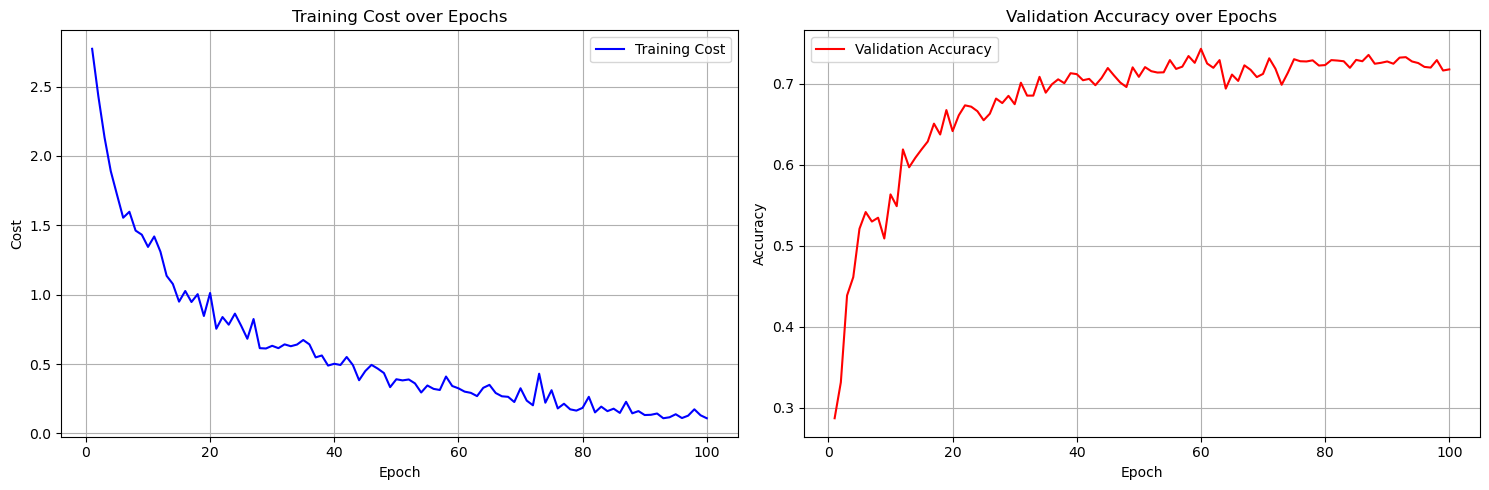

Final training cost: 0.1091
Final validation accuracy: 0.7175


In [11]:
mb_size = 512
learning_rate = 1e-4
epochs = 100
model = Sequential_layers([
    Linear(784, 200), 
    ReLU(), 
    Linear(200, 24)]
)

costs = []
accuracies = []

train(model, epochs, mb_size, learning_rate)
plot_training_progress(costs, accuracies)


We obtained 70% and we notice that aroung the 60 epochs there is no further improvement.
We can reduce the number of epochs, add another linear layer+ReLU, and duplicate the neurons in the hiddenn layer we can improve up to 80% of accuracy.


costo: 2.8593659375182194, accuracy: 0.22030117122141663
costo: 2.548028262151169, accuracy: 0.2833240379252649
costo: 2.0427773756917063, accuracy: 0.3890128276631344
costo: 2.1201390998674543, accuracy: 0.4966536530953709
costo: 1.4599508972160764, accuracy: 0.53792526491913
costo: 1.5243921855215135, accuracy: 0.5435025097601784
costo: 1.5970424293876884, accuracy: 0.528165086447295
costo: 1.361110209180595, accuracy: 0.5384829894032348
costo: 1.0478055961219335, accuracy: 0.5844952593418851
costo: 1.0759931469442843, accuracy: 0.6037367540435025
costo: 0.9449076050716096, accuracy: 0.6503067484662577
costo: 0.943347029701341, accuracy: 0.6514221974344674
costo: 0.7352411198000344, accuracy: 0.6656441717791411
costo: 0.7742543111602674, accuracy: 0.6988287785833798
costo: 0.6835039357217823, accuracy: 0.6862799776910207
costo: 0.789858769877683, accuracy: 0.7032905744562187
costo: 0.8084920339822598, accuracy: 0.675404350250976
costo: 0.6062857896936352, accuracy: 0.7325711098717234

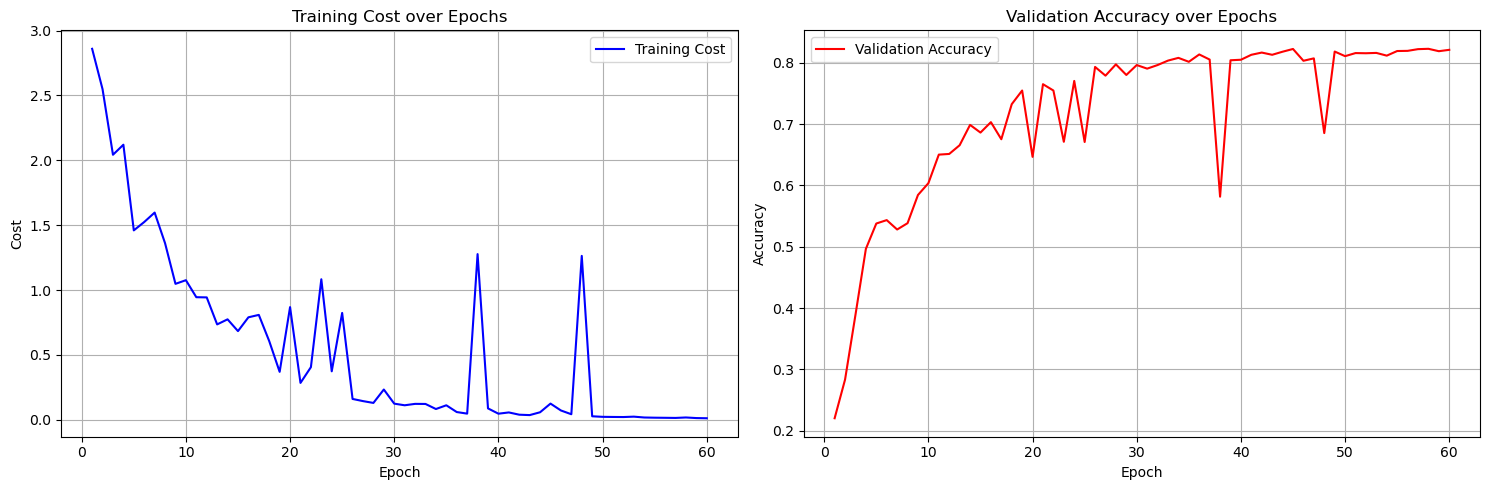

Final training cost: 0.0119
Final validation accuracy: 0.8212


In [12]:
mb_size = 512
learning_rate = 1e-4
epochs = 60

# Model definition

model2 = Sequential_layers([
    Linear(784, 400), 
    ReLU(), 
    Linear(400, 400), 
    ReLU(), 
    Linear(400, 400), 
    ReLU(), 
    Linear(400, 24)]    
)
costs = []
accuracies = []

train(model2, epochs, mb_size, learning_rate)
# Plot training progress after training
plot_training_progress(costs, accuracies)


Augmenting one more layers and increasing the neurons to 600. We obtain aroun 83%, we are probably reaching a zone of dimishing returns and we may experiment by tweaking changing the activation functions or adjusting the neurons in our model.


costo: 2.8978905401450414, accuracy: 0.25069715560513106
costo: 2.3920748211772795, accuracy: 0.47044060234244284
costo: 2.1400450596032146, accuracy: 0.44283324037925265
costo: 2.228745226092215, accuracy: 0.48354712771890684
costo: 1.7793223686841733, accuracy: 0.5527049637479086
costo: 1.3426952831413534, accuracy: 0.5688789737869493
costo: 1.1903292140922228, accuracy: 0.6503067484662577
costo: 1.237307894119342, accuracy: 0.6514221974344674
costo: 1.3190970969331473, accuracy: 0.63218070273285
costo: 1.112268276797574, accuracy: 0.6561628555493586
costo: 0.718608674368066, accuracy: 0.6940881204684886
costo: 0.9472322774431481, accuracy: 0.6578360290016732
costo: 1.1436010465453013, accuracy: 0.6514221974344674
costo: 0.35369016637907225, accuracy: 0.7791411042944786
costo: 0.5098956560188342, accuracy: 0.7598996095928612
costo: 0.4808493756743547, accuracy: 0.7841606246514222
costo: 0.39985359312880453, accuracy: 0.7601784718349136
costo: 0.2268854812007037, accuracy: 0.796430563

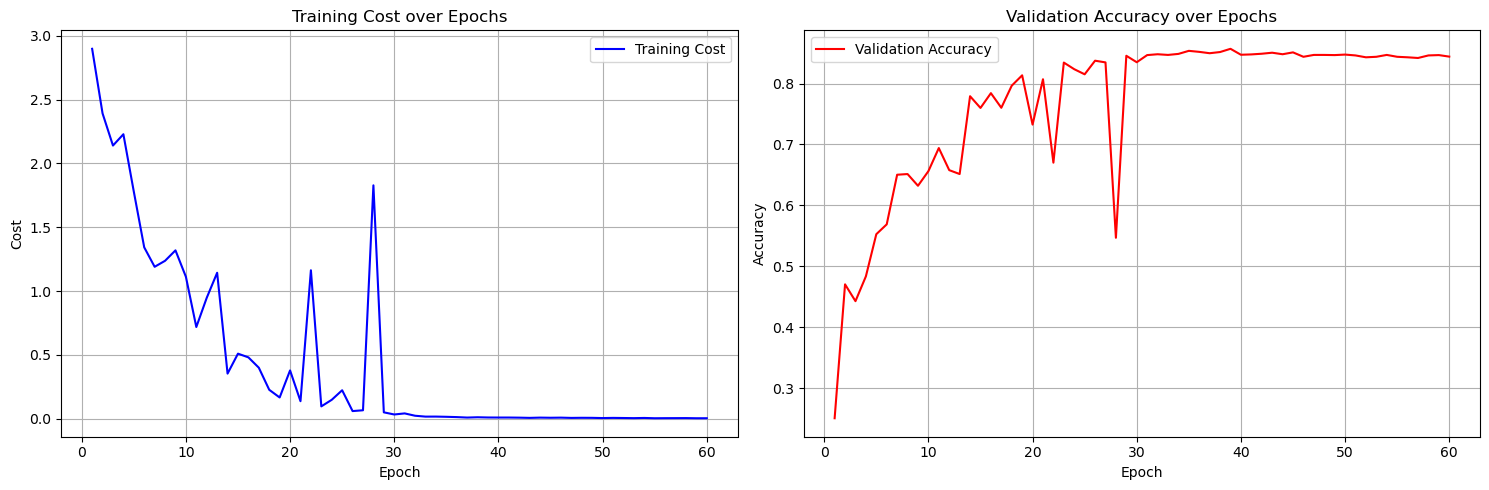

Final training cost: 0.0041
Final validation accuracy: 0.8441


In [13]:
mb_size = 512
learning_rate = 1e-4
epochs = 60

# Model definition

model3 = Sequential_layers([
    Linear(784, 600), 
    ReLU(), 
    Linear(600, 600), 
    ReLU(), 
    Linear(600, 600), 
    ReLU(), 
    Linear(600, 600), 
    ReLU(), 
    Linear(600, 24)]    
)
costs = []
accuracies = []

train(model3, epochs, mb_size, learning_rate)
# Plot training progress after training
plot_training_progress(costs, accuracies)


Finally we test the model with our test data and calculate the accuracy


Test set accuracy: 0.8369


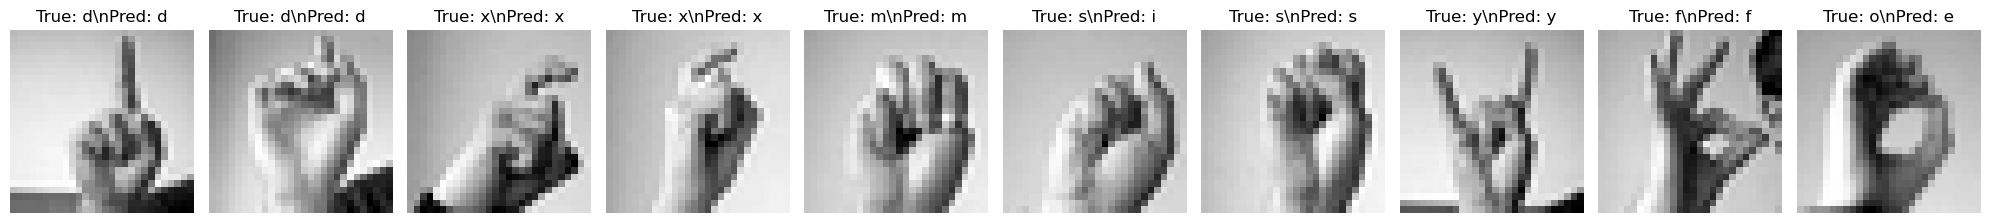

In [14]:
# Get test set accuracy
test_accuracy = accuracy(x_test_norm, y_test, mb_size, model3)
print(f"Test set accuracy: {test_accuracy:.4f}")

# Let's visualize some predictions
plt.figure(figsize=(20, 4))
test_batch_x, test_batch_y = next(create_minibatches(10, x_test_norm, y_test))
predictions = model3.predict(test_batch_x.T.view(np_tensor))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(test_batch_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'True: {get_asl_alphabet()[test_batch_y[i]]}\\nPred: {get_asl_alphabet()[predictions[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

